---

# Utilities Pipeline

### 00 Loading Data

In [1]:
%load_ext autoreload
%autoreload 2

from sklearn.pipeline import make_pipeline, make_union, FunctionTransformer
from sklearn.compose import make_column_transformer, make_column_selector

from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer

import pandas as pd
pd.options.display.float_format = '{:.2f}'.format


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from etl.utilities import Utilities

## Would load cleaned data using '''load.py''' once data cleaning is done
data = Utilities().get_training_data()

# create X and y
X = data.drop(columns='electricity_demmand')
y = data['electricity_demmand']

# create train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_features = list(X_train.columns)
data.dtypes
data.head(3)

,building_typology,building_gfa,year_built,occupancy,num_buildings,electricity_demmand
0,Office,169416,1909,95,1,1920103.60
1,K-12 School,94380,1963,100,1,180640.00
3,Hotel,50000,1994,100,1,579335.20


In [3]:
# use this cell to analyse train data

### 01 Preprocessor 🧮 (1. feature engineering + 2. enocding/scaling)

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion

# Define feature engineering functions
def calculate_occupied_area(data):
    data["occupied_area"] = data['building_gfa'] * (data['occupancy'] * 0.01)
    return data

def calculate_new_build(data):
    data["new_build"] = 0  # Initialize to 0
    
    # Update to 1 for rows where the condition is met
    data.loc[data['year_built'] >= 2000, 'new_build'] = 1
    
    return data

# convert functions to transformers
occupied_area = FunctionTransformer(calculate_occupied_area, validate=False)
new_build = FunctionTransformer(calculate_new_build, validate=False)

# create feature engineering tranformer
feature_engineering = ColumnTransformer(
    [
        ("occupied_area", occupied_area, ['building_gfa','occupancy' ]),
        ("new_build", new_build,['year_built'] )
    ],
    remainder="passthrough"
).set_output(transform = "pandas")

pd.DataFrame(feature_engineering.fit_transform(X_train))

c:\Users\hramzan\AppData\Local\anaconda3\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:343: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


,occupied_area__building_gfa,occupied_area__occupancy,occupied_area__occupied_area,new_build__year_built,new_build__new_build,remainder__building_typology,remainder__num_buildings
19729,41500,100,41500.00,1931,0,Multifamily Housing,1
18930,116400,100,116400.00,1911,0,Multifamily Housing,1
27131,82135,95,78028.25,2012,1,Multifamily Housing,1
4723,74270,100,74270.00,1910,0,Multifamily Housing,1
29649,37440,85,31824.00,1920,0,K-12 School,1
...,...,...,...,...,...,...,...
17669,56000,100,56000.00,1956,0,Multifamily Housing,1
18764,77770,100,77770.00,1925,0,Multifamily Housing,1
8058,152899,100,152899.00,1916,0,Multifamily Housing,1
1406,160454,100,160454.00,1909,0,Office,1


In [5]:
# OPTION 01 Encoding and Scaling
num_preproc = Pipeline([
    ("num_imputer", SimpleImputer(strategy = "constant", fill_value=0.)),
    ("scaler", RobustScaler())
])

cat_preproc = Pipeline([
    ("cat_imputer", SimpleImputer(strategy = "constant", fill_value="Missing")),
    ("ohe", OneHotEncoder(handle_unknown = "ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num_tr", num_preproc, make_column_selector(dtype_include = ["float64", "int64"])),
    ("cat_tr", cat_preproc, make_column_selector(dtype_include = ["object"]))
])
preprocessor
pd.DataFrame(preprocessor.fit_transform(X_train))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-0.37,-0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.61,-0.59,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.16,2.00,-5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.06,-0.62,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
4,-0.43,-0.36,-15.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15423,-0.18,0.56,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
15424,0.10,-0.23,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
15425,1.09,-0.46,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
15426,1.19,-0.64,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00


In [6]:
preprocessor = Pipeline([
    ("feature_engineering", feature_engineering),
    ("preprocessing", preprocessor)]).set_output(transform = "pandas")

preprocessor

c:\Users\hramzan\AppData\Local\anaconda3\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:343: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


Pipeline(steps=[('feature_engineering',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('occupied_area',
                                                  FunctionTransformer(func=<function calculate_occupied_area at 0x0000019C20916D40>),
                                                  ['building_gfa',
                                                   'occupancy']),
                                                 ('new_build',
                                                  FunctionTransformer(func=<function calculate_new_build at 0x0000019C20916FC0>),
                                                  ['year_built'])])),
                ('preprocessing',
                 Col...
                                                                   RobustScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000019C3C42E950>),
                                                 ('cat_tr',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000019C37406450>)]))])

In [7]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_train_transformed

print("Original training set")
display(X_train.head(3))

print("Preprocessed training set")
# display(pd.DataFrame(X_train_transformed, columns=['occupied_area'] + preprocessor.get_feature_names_out()).head(5))
display(pd.DataFrame(X_train_transformed))

Original training set


,building_typology,building_gfa,year_built,occupancy,num_buildings
19729,Multifamily Housing,41500,1931,100,1
18930,Multifamily Housing,116400,1911,100,1
27131,Multifamily Housing,82135,2012,95,1


Preprocessed training set


,num_tr__occupied_area__building_gfa,num_tr__occupied_area__occupancy,num_tr__occupied_area__occupied_area,num_tr__new_build__year_built,num_tr__new_build__new_build,num_tr__remainder__num_buildings,cat_tr__remainder__building_typology_College/University,cat_tr__remainder__building_typology_Courthouse,cat_tr__remainder__building_typology_Hospital (General Medical & Surgical),cat_tr__remainder__building_typology_Hotel,cat_tr__remainder__building_typology_K-12 School,cat_tr__remainder__building_typology_Laboratory,cat_tr__remainder__building_typology_Multifamily Housing,cat_tr__remainder__building_typology_Museum,cat_tr__remainder__building_typology_Office,cat_tr__remainder__building_typology_Other - Mall,cat_tr__remainder__building_typology_Performing Arts,cat_tr__remainder__building_typology_Prison/Incarceration,cat_tr__remainder__building_typology_Retail Store
19729,-0.37,0.00,-0.36,-0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
18930,0.61,0.00,0.62,-0.59,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
27131,0.16,-5.00,0.12,2.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
4723,0.06,0.00,0.07,-0.62,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
29649,-0.43,-15.00,-0.49,-0.36,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17669,-0.18,0.00,-0.17,0.56,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
18764,0.10,0.00,0.11,-0.23,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
8058,1.09,0.00,1.10,-0.46,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
1406,1.19,0.00,1.20,-0.64,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00


### 02 Fitting Model 🧠 

In [8]:
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

pipeline = make_pipeline(preprocessor, GradientBoostingRegressor())
pipeline


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('feature_engineering',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('occupied_area',
                                                                   FunctionTransformer(func=<function calculate_occupied_area at 0x0000019C20916D40>),
                                                                   ['building_gfa',
                                                                    'occupancy']),
                                                                  ('new_build',
                                                                   FunctionTransformer(func=<function calculate_new_build at 0x0000019C20916FC0>),
                                                                   ['year_buil...
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x0000019C3C42E950>),
                                                                  ('cat_tr',
                                                                   Pipeline(steps=[('cat_imputer',
                                                                                    SimpleImputer(fill_value='Missing',
                                                                                                  strategy='constant')),
                                                                                   ('ohe',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse_output=False))]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x0000019C37406450>)]))])),
                ('gradientboostingregressor', GradientBoostingRegressor())])

In [9]:
# train pipeline
pipeline.fit(X_train, y_train)

# Score model
score = pipeline.score(X_test, y_test)
print(f'score: {round(score, 2)}')

score: 0.86


### 03 Optimising pipeline 🔍

In [10]:
# which params are searchable
pipeline.get_params()

{'memory': None,
 'steps': [('pipeline', Pipeline(steps=[('feature_engineering',
                    ColumnTransformer(remainder='passthrough',
                                      transformers=[('occupied_area',
                                                     FunctionTransformer(func=<function calculate_occupied_area at 0x0000019C20916D40>),
                                                     ['building_gfa',
                                                      'occupancy']),
                                                    ('new_build',
                                                     FunctionTransformer(func=<function calculate_new_build at 0x0000019C20916FC0>),
                                                     ['year_built'])])),
                   ('preprocessing',
                    Col...
                                                                      RobustScaler())]),
                                                     <sklearn.compose._column_transfo

In [65]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# which params are searchable
pipeline.get_params()

# define params to search
param_distributions = {
    # imputer
     'pipeline__preprocessing__num_tr__num_imputer__strategy': ['mean','constant','most_frequent'],
    
    #scaler
    # 'pipeline__preprocessing__num_tr__scaler__with_mean': [True, False],
    # 'pipeline__preprocessing__num_tr__scaler__with_std': [True, False],
    # 'pipeline__preprocessing__num_tr__scaler__unit_variance': [True,False],
    # 'pipeline__preprocessing__num_tr__scaler__with_centering': [True,False],
    # 'pipeline__preprocessing__num_tr__scaler__with_scaling': [True,False],

    # model
    # 'sgdregressor__alpha': [ 0.001, 0.0005, 0.0001],
    # 'sgdregressor__loss': ['huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    # 'sgdregressor__penalty': ['l2', 'l1', 'elasticnet', 'None'],
    # 'gradientboostingregressor__n_estimators': np.arange(50, 100, 10),
    # 'gradientboostingregressor__learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    # 'gradientboostingregressor__max_depth': [3, 5, 7, 9],
    # 'gradientboostingregressor__min_samples_split': [2, 5, 10],
    # 'gradientboostingregressor__min_samples_leaf': [1, 2, 4],
    # 'gradientboostingregressor__subsample': [0.8, 0.9, 1.0]
}

randomized_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=10,
    cv=5,
    scoring='r2'
)

randomized_search.fit(X_train,y_train)
randomized_search.best_params_

c:\Users\hramzan\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'pipeline__preprocessing__num_tr__num_imputer__strategy': 'constant'}

In [12]:
pipeline_tuned = randomized_search.best_estimator_

# Score tuned model
tuned_score = pipeline_tuned.score(X_test, y_test)

print(f'score: {round(tuned_score, 2)}')

score: 0.86


### 04 Debugging the pipe 🐞

In [13]:
# Access the components of a Pipeline with `named_steps`
pipeline_tuned.named_steps.keys()
# pipeline_tuned

dict_keys(['pipeline', 'gradientboostingregressor'])

In [14]:
# Check intermediate steps
print("Before preprocessing, X_train.shape = ")
print(X_train.shape)
print("After preprocessing, X_train_preprocessed.shape = ")
pipeline_tuned.named_steps["pipeline"].fit_transform(X_train).shape # notice the extra columnns as a result of the ordinal encoder

Before preprocessing, X_train.shape = 
(15428, 5)
After preprocessing, X_train_preprocessed.shape = 


(15428, 19)

In [15]:
# Plotting the learning Curves
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve


# Define training sizes (percentages of the dataset)
train_sizes = np.linspace(0.1, 1.0, 20)

# Create learning curves
train_sizes, train_scores, validation_scores = learning_curve(
    pipeline, X_train, y_train, train_sizes=train_sizes, cv=10, scoring='r2', n_jobs=-1
)

# Calculate mean and standard deviation for training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

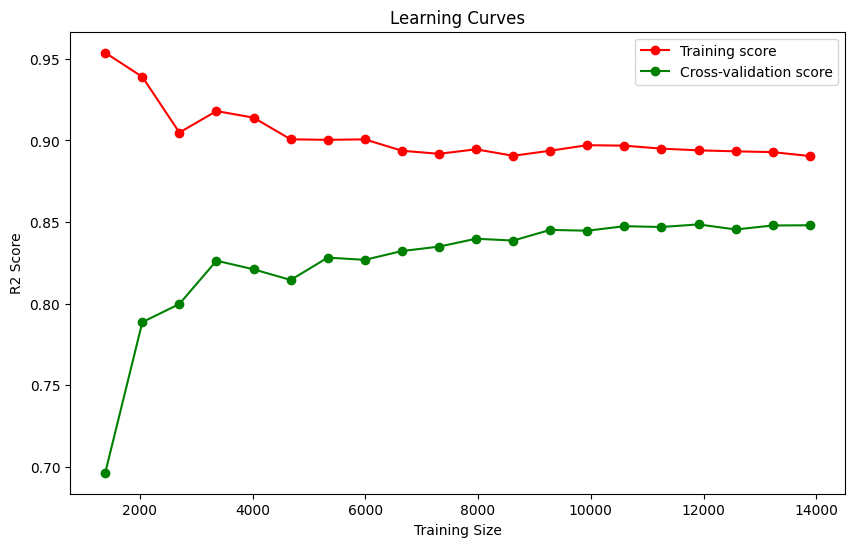

In [16]:
# Plot learning curves
plt.figure(figsize=(10, 6))
# plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
# plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std, validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")

# Add labels and title
plt.xlabel("Training Size")
plt.ylabel("R2 Score")
plt.title("Learning Curves")
plt.legend(loc="best")
plt.show()

### 05 Exporting the pipeline as a pickle 🥒

In [17]:
# breakpoint()

In [18]:
import pickle

# export pipe as pickle file
with open('pipeline/pipeline.pkl', 'wb') as file:
    pickle.dump(pipeline_tuned, file)

In [19]:
# load pickle back into test
pipe = pickle.load(open('pipeline/pipeline.pkl', 'rb'))

In [64]:
y_pred = pipe.predict(X_test)

results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

# Select a random sample of rows without specifying random_state
random_sample = results_df.sample(20)

# Calculate percentage difference and add a new column
random_sample['Percentage Difference'] = abs((random_sample['Predicted'] - random_sample['Actual']) / random_sample['Actual']) * 100

# Rearrange columns to place 'Actual', 'Predicted', and 'Percentage Difference' at the end
columns_order = [col for col in random_sample.columns if col not in ['Actual', 'Predicted', 'Percentage Difference']] + ['Actual', 'Predicted', 'Percentage Difference']
random_sample = random_sample[columns_order]

# Display the selected sample along with the corresponding features from X_test
sample_with_features = pd.concat([random_sample, X_test.loc[random_sample.index]], axis=1).sort_values('Percentage Difference')

# Display the selected sample along with the corresponding features from X_test with styling
(pd.concat([random_sample, X_test.loc[random_sample.index]], axis=1)
 .sort_values('Percentage Difference')
 .style.applymap(lambda val: 'color: red' if val > 20 else 'color: black', subset=['Percentage Difference']))

,Actual,Predicted,Percentage Difference,building_typology,building_gfa,year_built,occupancy,num_buildings
22475,197276.900000,203733.760646,3.272994,Multifamily Housing,41890,1928,100,1
18469,196499.900000,171945.596884,12.495835,Multifamily Housing,30000,1931,95,1
12532,419360.000000,484807.427286,15.606502,K-12 School,78000,1895,100,1
2043,3657714.100000,4251007.205555,16.220325,Office,274116,1915,100,1
23348,324348.800000,244869.672436,24.504215,Multifamily Housing,52750,1962,100,1
6094,258483.800000,193938.437812,24.970757,Multifamily Housing,40344,1960,100,1
17236,439529.800000,320627.585812,27.052139,Multifamily Housing,71820,1938,100,1
10308,724399.900000,523535.399291,27.728400,Courthouse,39150,1894,100,1
5065,418940.800000,541730.240796,29.309497,Multifamily Housing,64753,2000,100,1
25485,3602132.500000,2216713.698506,38.461073,Multifamily Housing,244249,2009,100,1
